In [1]:
import os.path
import pandas as pd
import numpy as np
import math
import scipy.ndimage as ndimage
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [3]:
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

### Get Indices

In [4]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should divide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)
transform = torchvision.transforms.ToTensor()

### Labeled Dataset

In [5]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)

### Average 6 images

In [14]:
sample, target, road_image, extra = iter(trainloader).next()
samples = torch.stack(sample)
print(samples.shape)
avg_samples = torch.mean(samples,axis=1)
print(avg_samples.shape)

torch.Size([1, 6, 3, 256, 306])
torch.Size([1, 3, 256, 306])


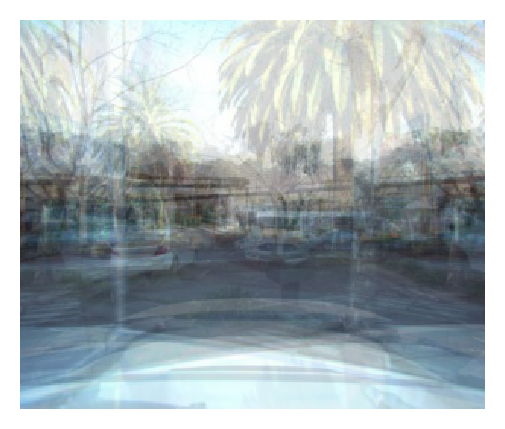

In [8]:
avg_img = avg_samples[0].numpy().transpose(1,2,0)
plt.figure(figsize=(3,3))
plt.imshow(avg_img)
plt.axis('off');

### Roadmap Exploration

torch.Size([800, 800])


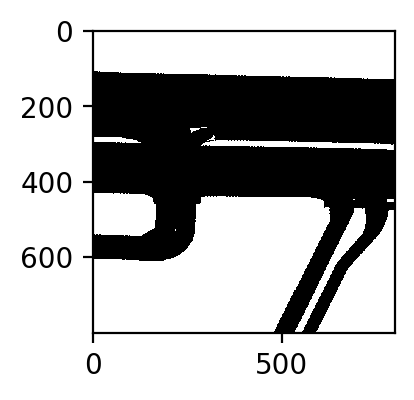

In [9]:
print(road_image[0].shape)
fig, ax = plt.subplots(figsize=(10, 2));
ax.imshow(road_image[0], cmap='binary');

### UNet for Roadmap Prediction

In [6]:
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()
                
class _EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super(_EncoderBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.encode = nn.Sequential(*layers)

    def forward(self, x):
        return self.encode(x)


class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBlock, self).__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.decode(x)
    
class UNet(nn.Module):
    def __init__(self,num_classes):
        super(UNet, self).__init__()
        self.enc1 = _EncoderBlock(3, 64)
        self.enc2 = _EncoderBlock(64, 128)
        self.enc3 = _EncoderBlock(128, 256)
        self.enc4 = _EncoderBlock(256, 512, dropout=True)
        self.center = _DecoderBlock(512, 1024, 512)
        self.dec4 = _DecoderBlock(1024, 512, 256)
        self.dec3 = _DecoderBlock(512, 256, 128)
        self.dec2 = _DecoderBlock(256, 128, 64)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.final = nn.Conv2d(64, num_classes, kernel_size=1) #2 because binary 0/1
        initialize_weights(self)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        center = self.center(enc4)
        dec4 = self.dec4(torch.cat([center, F.interpolate(enc4, center.size()[2:], mode='bilinear',align_corners=True)], 1))
        dec3 = self.dec3(torch.cat([dec4, F.interpolate(enc3, dec4.size()[2:], mode='bilinear',align_corners=True)], 1))
        dec2 = self.dec2(torch.cat([dec3, F.interpolate(enc2, dec3.size()[2:], mode='bilinear',align_corners=True)], 1))
        dec1 = self.dec1(torch.cat([dec2, F.interpolate(enc1, dec2.size()[2:], mode='bilinear',align_corners=True)], 1))
        final = self.final(dec1)
        output = F.interpolate(final, 800, mode='bilinear',align_corners=True) #upsample to be 800x800
        return output

Training Function for UNet

In [7]:
def train(model, device, trainloader, optimizer, epoch, log_interval = 500):
    # Set model to training mode
    model.train()

    # Loop through data points
    for batch_idx,(sample, target, road_image, extra) in enumerate(trainloader):

        model_input = torch.mean(torch.stack(sample),axis=1)
        #convert bool tensor to long
        roadmaps = tuple(road_image[i].long() for i in range(1)) #batch_size 1
        
        #[batch_size, 800,800]
        roadmaps = torch.stack(roadmaps)
        
        # Send data and target to device
        model_input, roadmaps = model_input.to(device), roadmaps.to(device)
        
        # Zero out the ortimizer
        optimizer.zero_grad()
        
        # Pass data through model
        preds = model(model_input) #returns [2,2,800,800]
        preds = F.log_softmax(preds,dim=1)

        # Compute the negative log likelihood loss
        loss = F.nll_loss(preds, roadmaps)

        # Backpropagate loss
        loss.backward()
        
        # Make a step with the optimizer
        optimizer.step()

        # Print loss (uncomment lines below once implemented)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * 2, len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))

In [8]:
# Define model and sent to device
model = UNet(num_classes=2)
model.to(device)

# Optimizer: SGD with learning rate of 1e-2 and momentum of 0.5
optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.5)

# Training loop with 10 epochs
for epoch in range(1, 11):

    # Train model
    train(model, device, trainloader, optimizer, epoch)
    torch.save(model.state_dict(), 'UNet')

Train Epoch: 1 [0/3528 (0%)]	Loss: 1.306519
Train Epoch: 1 [1000/3528 (14%)]	Loss: 0.365567
Train Epoch: 1 [2000/3528 (28%)]	Loss: 0.512137
Train Epoch: 1 [3000/3528 (43%)]	Loss: 0.369003
Train Epoch: 1 [4000/3528 (57%)]	Loss: 0.211213
Train Epoch: 1 [5000/3528 (71%)]	Loss: 0.378442
Train Epoch: 1 [6000/3528 (85%)]	Loss: 0.295580
Train Epoch: 1 [7000/3528 (99%)]	Loss: 0.178566
Train Epoch: 2 [0/3528 (0%)]	Loss: 0.493063
Train Epoch: 2 [1000/3528 (14%)]	Loss: 0.436045
Train Epoch: 2 [2000/3528 (28%)]	Loss: 0.428465
Train Epoch: 2 [3000/3528 (43%)]	Loss: 0.363656
Train Epoch: 2 [4000/3528 (57%)]	Loss: 0.472255
Train Epoch: 2 [5000/3528 (71%)]	Loss: 0.539999
Train Epoch: 2 [6000/3528 (85%)]	Loss: 0.245073
Train Epoch: 2 [7000/3528 (99%)]	Loss: 0.289514
Train Epoch: 3 [0/3528 (0%)]	Loss: 0.618611
Train Epoch: 3 [1000/3528 (14%)]	Loss: 0.336452
Train Epoch: 3 [2000/3528 (28%)]	Loss: 0.108111
Train Epoch: 3 [3000/3528 (43%)]	Loss: 0.464514
Train Epoch: 3 [4000/3528 (57%)]	Loss: 0.553755
Trai

Testing Function for UNet

In [11]:
# Define test method
def test(model, device, test_loader):
    # Set model to evaluation mode
    model.eval()
    # Variable for the total loss 
    test_loss = 0
    # Counter for the correct predictions
    num_correct = 0
    
    # don't need autograd for eval
    with torch.no_grad():
        # Loop through data points
        for batch_idx,(sample, target, road_image, extra) in enumerate(test_loader):
            
            model_input = torch.mean(torch.stack(sample),axis=1)
            #convert bool tensor to long
            roadmaps = tuple(road_image[i].long() for i in range(2))
            
            #[batch_size, 800,800]
            roadmaps = torch.stack(roadmaps)

            # Send data to device
            model_input, roadmaps = model_input.to(device), roadmaps.to(device)
            
            # Pass data through model
            output = model(model_input)
            output = F.log_softmax(output,dim=1)
            
            # Compute the negative log likelihood loss with reduction='sum' and add to total test_loss
            test_loss += F.nll_loss(output, roadmaps, reduction='sum').item()
            
            # Get predictions (indices) from the model for each data point
            model_preds = output.data.max(1,keepdim=True)[1]

#             #plot prediction vs actual
#             #prediction
#             fig, ax = plt.subplots(figsize=(5, 2));
#             pred_roadmap = model_preds[0].squeeze(0).cpu()
#             ax.imshow(pred_roadmap, cmap='binary');
            
#             #actual
#             fig, ax = plt.subplots(figsize=(5, 2));
#             actual_roadmap = roadmaps[0].cpu()
#             ax.imshow(actual_roadmap, cmap='binary');
            
            # Add number of correct predictions to total num_correct 
                # adds an extra dimension to roadmaps to match model_preds
                # [batch_size,800,800]-->[batch_size,1,800,800]
                # compares them element-wise
            num_correct += model_preds.eq(roadmaps.data.view_as(model_preds)).cpu().sum().item()
           
    
    # Compute the average test_loss
    total_pixels = len(test_loader.dataset)*800**2 #for 800x800 pixel grid
    avg_test_loss = test_loss/total_pixels
    
    # Print loss (uncomment lines below once implemented)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_test_loss, num_correct, total_pixels,
        100. * num_correct / total_pixels))

In [12]:
# Define model, load from saved trained model, and sent to device
model = UNet(num_classes=2)
model.load_state_dict(torch.load('UNet'))
model.to(device)

for epoch in range(1):
    # Test model
    test(model, device, trainloader)

torch.Size([2, 800, 800])
